<a href="https://colab.research.google.com/github/ybchen97/filler_detection/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

Syncing from google drive and github... for more info on this code, refer [here](https://zerowithdot.com/colab-github-workflow/)

In [15]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive

drive.mount(ROOT)           # we mount the drive at /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
GIT_PATH = "https://github.com/ybchen97/filler_detection.git"
!mkdir ./temp
!git clone "{GIT_PATH}"
!mv ./temp/* "{PROJECT_PATH}"
!rm -rf ./temp

Cloning into 'filler_detection'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 4988 (delta 60), reused 35 (delta 19), pack-reused 4887
Receiving objects: 100% (4988/4988), 841.63 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (506/506), done.
mv: cannot stat './temp/*': No such file or directory


Install packages in this local notebook specified in requirements.txt

In [0]:
!pip install -r '/content/filler_detection/requirements.txt'

     |████████████████████████████████| 194kB 6.1MB/s 
     |████████████████████████████████| 122kB 21.4MB/s 
     |████████████████████████████████| 163kB 19.4MB/s 
     |████████████████████████████████| 573kB 19.6MB/s 
     |████████████████████████████████| 9.5MB 10.6MB/s 
     |████████████████████████████████| 839kB 57.9MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 2.7MB 59.6MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 122kB 60.8MB/s 
     |████████████████████████████████| 788kB 65.2MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 1.1MB 74.0MB/s 
     |████████████████████████████████| 133kB 75.2MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
     |████████████████████████████████| 112kB 74.8MB/s 
     |████████████████████████████████| 92kB 11.8MB/s 
   

Importing and setting up env variables...

In [0]:
import numpy as np
from pydub import AudioSegment
from pydub.playback import play
import random
import sys
import io
import os
import glob
import IPython
import wave
import pylab
from tf_utils import *
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import pickle

# Import files for trigger-word detection model
import keras.backend as K
import tensorflow as tf
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape, ConvLSTM2D, Lambda
from keras.optimizers import Adam
from keras.callbacks.callbacks import EarlyStopping
from sklearn.utils import class_weight

# For reproducibility
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(1337)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

random.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.random.set_seed(1234)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


In [0]:
PROJ_PATH = '/content/drive/My Drive/filler_detection/'

### Create New Model (if not pre-trained)

Sanity check for `Tx`, `n_freq`, `Ty`. 

1. Input into model `Tx` and `n_freq`
2. Call `model.summary()`
3. `Tx` of **sample** and variable = `input_7.shape[1]` (ie column 2, row 1, second element of array)
4. `Ty` = `input_7.shape[1]` (ie column 2, row 2, second element of array)

In [0]:
Tx = 5490 # The number of time steps input to the model from the spectrogram
n_freq = 129 # Number of frequencies input to the model at each time step of the spectrogram
Ty = 1369 # The number of time steps in the output of our model

In [0]:
from keras.initializers import RandomNormal

# GRADED FUNCTION: model

def create_gru(input_shape, output_bias=None, dropout=0.8):
    """
    Function creating the model's graph in Keras library.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    
    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV Layer
    # CONV-1D
    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input)
    # Batch Normalization
    X = BatchNormalization()(X)
    # RelU activation
    X = Activation("relu")(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    
    # Step 2: First GRU Layer
    # GRU (use 128 units to return the sequences)
    X = GRU(units=128, return_sequences=True)(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    
    # Step 3: Second GRU Layer
    # GRU (use 128 units to return the sequences)
    X = GRU(units=128, return_sequences=True)(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    
    # Step 4: Time-distributed dense layer
    if output_bias != None: 
        bias_initializer = RandomNormal(mean=output_bias) 
    else: 
        bias_initializer = "zeros"
    X = TimeDistributed(Dense(1, activation="sigmoid", bias_initializer= bias_initializer))(X)
    
    # Return model
    model = Model(inputs = [X_input], outputs = X)
    return model

In [0]:
from keras.initializers import RandomNormal

# GRADED FUNCTION: model

def create_lstm(input_shape, output_bias=None, dropout=0.8):
    """
    Function creating the model's graph in Keras library.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    
    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV Layer
    # CONV-1D
    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input)
    # Batch Normalization
    X = BatchNormalization()(X)
    # RelU activation
    X = Activation("relu")(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    
    # Step 2: First lstm Layer
    # bi-lsem (use 128 units to return the sequences)
    X = LSTM(units=128, return_sequences=True)(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    
    # Step 3: Second lstm Layer
    # lstm (use 128 units to return the sequences)
    X = LSTM(units=128, return_sequences=True)(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    
    # Step 4: Time-distributed dense layer
    if output_bias != None: 
        bias_initializer = RandomNormal(mean=output_bias) 
    else: 
        bias_initializer = "zeros"
    X = TimeDistributed(Dense(1, activation="sigmoid", bias_initializer= bias_initializer))(X)
    
    # Return model
    model = Model(inputs = [X_input], outputs = X)
    return model

In [0]:
from keras.initializers import RandomNormal

# GRADED FUNCTION: model

def create_bigru(input_shape, output_bias=None, dropout=0.8):
    """
    Function creating the model's graph in Keras library.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    
    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV Layer
    # CONV-1D
    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input)
    # Batch Normalization
    X = BatchNormalization()(X)
    # RelU activation
    X = Activation("relu")(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    
    # Step 2: First Bi-GRU Layer
    # Bi-GRU (use 128 units to return the sequences)
    X = Bidirectional(GRU(units=128, return_sequences=True))(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    
    # Step 3: Second Bi-GRU Layer
    # Bi-GRU (use 128 units to return the sequences)
    X = Bidirectional(GRU(units=128, return_sequences=True))(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    
    # Step 4: Time-distributed dense layer
    if output_bias != None: 
        bias_initializer = RandomNormal(mean=output_bias) 
    else: 
        bias_initializer = "zeros"
    X = TimeDistributed(Dense(1, activation="sigmoid", bias_initializer= bias_initializer))(X)
    
    # Return model
    model = Model(inputs = [X_input], outputs = X)
    return model

In [0]:
from keras.initializers import RandomNormal

# GRADED FUNCTION: model

def create_bilstm(input_shape, output_bias=None, dropout=0.8):
    """
    Function creating the model's graph in Keras library.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    
    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV Layer
    # CONV-1D
    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input)
    # Batch Normalization
    X = BatchNormalization()(X)
    # RelU activation
    X = Activation("relu")(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    
    # Step 2: First bi-lstm Layer
    # bi-lstm (use 128 units to return the sequences)
    X = Bidirectional(LSTM(units=128, return_sequences=True))(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    
    # Step 3: Second bi-lstm Layer
    # bi-lstm (use 128 units to return the sequences)
    X = Bidirectional(LSTM(units=128, return_sequences=True))(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    
    # Step 4: Time-distributed dense layer
    if output_bias != None: 
        bias_initializer = RandomNormal(mean=output_bias) 
    else: 
        bias_initializer = "zeros"
    X = TimeDistributed(Dense(1, activation="sigmoid", bias_initializer= bias_initializer))(X)
    
    # Return model
    model = Model(inputs = [X_input], outputs = X)
    return model

In [0]:
from keras.initializers import RandomNormal

# GRADED FUNCTION: model

def create_convlstm2d(input_shape, output_bias=None, dropout=0.8):
    """
    Function creating the model's graph in Keras library.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    
    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    X = Lambda(lambda x: K.expand_dims(x, axis = 2))(X_input)
    X = Lambda(lambda x: K.expand_dims(x, axis = 1))(X)
    # X = K.expand_dims(X, axis = 1)
    print(X)
    
    # Step 2: First bi-lstm Layer
    # bi-lsem (use 128 units to return the sequences)
    X = Bidirectional(ConvLSTM2D(filters=196, kernel_size=(15, 1), strides=4, return_sequences=True))(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    
    # Step 3: Second bi-lstm Layer
    # lstm (use 128 units to return the sequences)
    X = Bidirectional(ConvLSTM2D(filters=196, kernel_size=(1, 1), strides=1, return_sequences=True))(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    
    # Step 4: Time-distributed dense layer
    if output_bias != None: 
        bias_initializer = RandomNormal(mean=output_bias) 
    else: 
        bias_initializer = "zeros"
    X = TimeDistributed(Dense(1, activation="sigmoid", bias_initializer= bias_initializer))(X)
    X = Reshape((Ty, 1))(X)
    
    # Return model
    model = Model(inputs = [X_input], outputs = X)
    return model

In [29]:
model = create_bigru(input_shape = (Tx, n_freq), output_bias = None)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 5490, 129)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1369, 196)         379456    
_________________________________________________________________
batch_normalization_7 (Batch (None, 1369, 196)         784       
_________________________________________________________________
activation_3 (Activation)    (None, 1369, 196)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1369, 196)         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 1369, 256)         249600    
_________________________________________________________________
dropout_10 (Dropout)         (None, 1369, 256)         0   

In [0]:
model = create_convlstm2d(input_shape = (Tx, n_freq))
model.summary()

Tensor("lambda_2/ExpandDims:0", shape=(None, 1, 5490, 1, 129), dtype=float32)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5490, 129)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 5490, 1, 129)      0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 1, 5490, 1, 129)   0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1, 1369, 1, 392)   7645568   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 1369, 1, 392)   0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1, 1369, 1, 392)   1568      
_______________________________________________

### Load Weights of Pre-trained Model
Loaded weights instead of model due to custom metrics causing error in loading model directly. Read more [here](https://github.com/keras-team/keras/issues/10104).

In [20]:
model.load_weights(PROJ_PATH + "models/bryan_bigru.h5") 
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5490, 129)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1369, 196)         379456    
_________________________________________________________________
batch_normalization_4 (Batch (None, 1369, 196)         784       
_________________________________________________________________
activation_2 (Activation)    (None, 1369, 196)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1369, 196)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1369, 256)         249600    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1369, 256)         0   

## Model Training

In [0]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [0]:
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [0]:
import keras

# Function to fit and further train the model. Returns history (check documentation of `model.fit` for more details).
def model_train(model, X, Y, X_dev, Y_dev):
    """
    Function to train the model further using Adam optimiser and binary 
    cross entropy loss.
    
    Arguments:
    model -- Model to train
    X -- X data to train on
    Y -- Y data to train on
    """

    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
    ]

    es = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', 
                                            min_delta=0, 
                                            patience=20, 
                                            verbose=1, 
                                            mode='auto', 
                                            baseline=None, 
                                            restore_best_weights=True)

    
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
    model.compile(loss=f1_loss, optimizer=opt, metrics=METRICS)
    
    history = model.fit(X, Y, batch_size=50, epochs=100, validation_data=(X_dev, Y_dev), callbacks = [es])
    return history

In [31]:
X = np.load(PROJ_PATH + "data/train/bryan_lectures/X.npy")
Y = np.load(PROJ_PATH + "data/train/bryan_lectures/Y.npy")
print("X: {} Y: {}".format(X.shape, Y.shape))

X: (1000, 5490, 129) Y: (1000, 1369, 1)


In [34]:
X_dev = np.load(PROJ_PATH + "data/dev_synthesised/bryan_lectures/X_dev.npy")
Y_dev = np.load(PROJ_PATH + "data/dev_synthesised/bryan_lectures/Y_dev.npy")
print("X: {} Y: {}".format(X_dev.shape, Y_dev.shape))

X: (100, 5490, 129) Y: (100, 1369, 1)


In [33]:
model_filename = "bryan_bigru_retrain"
history_filename = "bryan_bigru_retrain"

history = model_train(model, X, Y, X_dev, Y_dev)

# Save model
model.save(PROJ_PATH + f"models/{model_filename}.h5")
print("model saved!")

# Save history
with open(PROJ_PATH + f'models/history/{history_filename}', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
print("history saved!")

Train on 1000 samples, validate on 100 samples
Epoch 1/100
 950/1000 [===========================>..] - ETA: 6s - loss: 0.8893 - tp: 45521.0000 - fp: 660408.0000 - tn: 568095.0000 - fn: 26526.0000 - accuracy: 0.4718 - precision: 0.0645 - recall: 0.6318 - auc: 0.5645 

InvalidArgumentError: ignored

# New Section

# New Section

# New Section

## Model Evaluation Tools
1. Metrics (accuracy, f1, precision, recall). 
2. Visualising model's prediction
3. Visualising `Y.npy` to know where the ones are inserted.
4. Plot of metrics against epochs

In [21]:
X_test_dev = np.load(PROJ_PATH + "data/test/bryan_synthesised/X_test.npy")
Y_test_dev = np.load(PROJ_PATH + "data/test/bryan_synthesised/Y_test.npy")
print("X: {} Y: {}".format(X_test_dev.shape, Y_test_dev.shape))

X: (50, 5490, 129) Y: (50, 1369, 1)


In [22]:
X_test = np.load(PROJ_PATH + "data/test/bryan_cont/X_test.npy")
X_test = X_test[:50]
Y_test = np.load(PROJ_PATH + "data/test/bryan_cont/Y_test.npy")
Y_test = Y_test[:50]
print("X: {} Y: {}".format(X_test.shape, Y_test.shape))

X: (50, 5490, 129) Y: (50, 1369, 1)


### Plot of metrics against epochs

In [0]:
def plot_history(history):

    fig, axs = plt.subplots(2,3)
    fig.set_size_inches(15,7.5,forward=True)
    fig.tight_layout(pad=3.0)

    # Plot training & validation accuracy values
    axs[0,0].plot(history['accuracy'])
    axs[0,0].plot(history['val_accuracy'])
    axs[0,0].set_title('Model accuracy')
    axs[0,0].set_ylabel('Accuracy')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation loss values
    axs[0,1].plot(history['loss'])
    axs[0,1].plot(history['val_loss'])
    axs[0,1].set_title('Model loss')
    axs[0,1].set_ylabel('Loss')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].legend(['Train', 'Val'], loc='upper right')

    # Plot precision loss values
    axs[1,0].plot(history['precision'])
    axs[1,0].plot(history['val_precision'])
    axs[1,0].set_title('Model Precision')
    axs[1,0].set_ylabel('Precision')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].legend(['Train', 'Val'], loc='upper left')

    # Plot recall loss values
    axs[1,1].plot(history['recall'])
    axs[1,1].plot(history['val_recall'])
    axs[1,1].set_title('Model Recall')
    axs[1,1].set_ylabel('Recall')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].legend(['Train', 'Val'], loc='upper right')

    axs[0,2].plot(history['auc'])
    axs[0,2].plot(history['val_auc'])
    axs[0,2].set_title('Model AUC')
    axs[0,2].set_ylabel('AUC')
    axs[0,2].set_xlabel('Epoch')
    axs[0,2].legend(['Train', 'Val'], loc='upper right')

    axs[1,2].set_visible(not axs[1,2].get_visible())

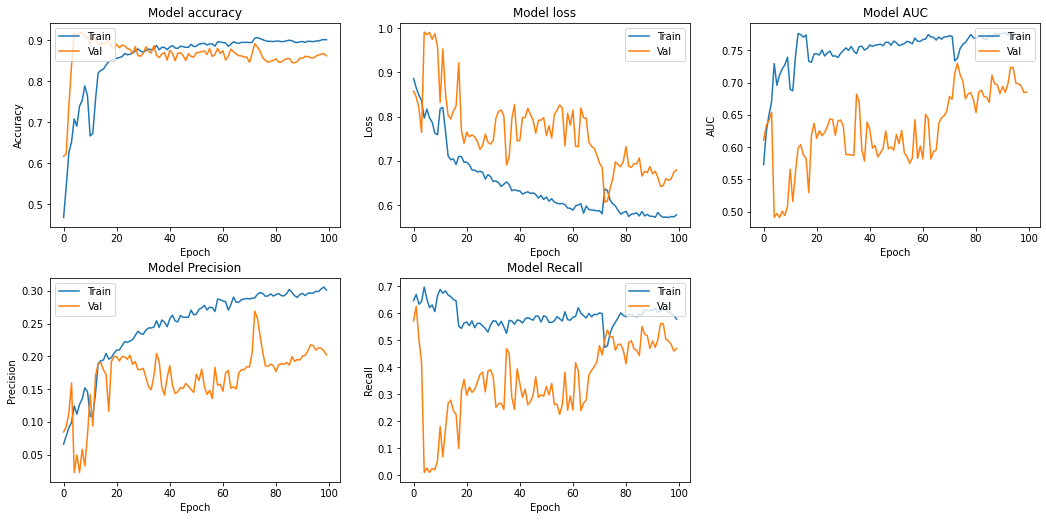

In [27]:
# Load history CHANGE HISTORY PATH HERE
history_filename = "bryan_bigru"
history = pickle.load(open(PROJ_PATH +f'models/history/{history_filename}', "rb"))
plot_history(history)

### Outputs accuracy, F1 score, precision, recall scores

In [0]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

# Evaluates the model on the test sets based on accuracy, precision, recall, and f1 score.
def evaluate_model(model, X_test, Y_test, threshold=0.5):
    # predict probabilities for dev set
    Y_predict = model.predict(X_test, verbose=0)
    # Applying sigmoid onto prediction of probabilities in order to use f-score
    Y_predict = np.where(Y_predict > 0.3, 1, 0)

    # flatten array in order to use fscore
    Y_test_flattened = Y_test.flatten()
    Y_predict_flattened = Y_predict.flatten()

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(Y_test_flattened, Y_predict_flattened)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(Y_test_flattened, Y_predict_flattened)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(Y_test_flattened, Y_predict_flattened)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(Y_test_flattened, Y_predict_flattened)
    print('F1 score: %f' % f1)

Plots model's prediction for each `Ty` step for the `%index` example

In [0]:
# visualises model's prediction on the %index example of training input X.
def visualize_prediction(model, X, index=0):
    Y_predict = model.predict(X, verbose=0)

    plt.subplot(2, 1, 2)
    plt.plot(Y_predict[index,:,0])
    plt.ylabel('probability')
    plt.show()

Plots `Ty` for the `%index` example

In [0]:
def plot_Y(Y, index=0):
    plt.plot(Y[index])

In [24]:
evaluate_model(model, X_test_dev, Y_test_dev)

Accuracy: 0.863871
Precision: 0.163715
Recall: 0.345714
F1 score: 0.222204


In [25]:
evaluate_model(model, X_test, Y_test)

Accuracy: 0.869102
Precision: 0.078051
Recall: 0.090568
F1 score: 0.083845


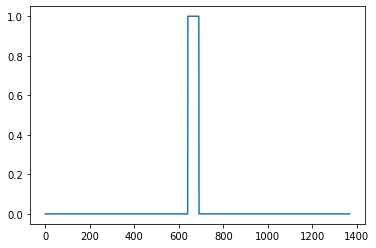

In [0]:
plot_Y(Y_test_dev, 3)

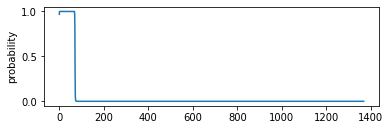

In [0]:
visualize_prediction(model, X_test_dev, 3)

## Saving the model

In [0]:
model.save(PROJ_PATH + "models/please_save_me.h5")

## [Doesn't work] Confirming that the bias fix helps


In [0]:
zero_bias_model = create_model(input_shape = (Tx, n_freq), output_bias = None)
model_train(model, X, Y, X_dev, Y_dev)

Train on 100 samples, validate on 50 samples
Epoch 1/1
100/100 [==============================] - 109s 1s/step - loss: 1.0449 - val_loss: 0.6329


In [0]:
careful_bias_model = create_model(input_shape = (Tx, n_freq), output_bias = initial_bias)
model_train(model, X, Y, X_dev, Y_dev)

Train on 100 samples, validate on 50 samples
Epoch 1/1
100/100 [==============================] - 106s 1s/step - loss: 0.9929 - val_loss: 0.6188


In [0]:
evaluate_model(zero_bias_model, X_test, Y_test, 0.3)
evaluate_model(careful_bias_model, X_test, Y_test, 0.3)

Accuracy: 0.256947
Precision: 0.036460
Recall: 0.777778
F1 score: 0.069654
Accuracy: 0.964237
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
visualize_prediction(model, X_test)

NameError: ignored

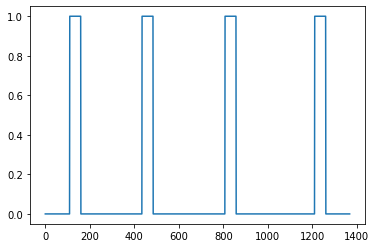

In [0]:
plt.plot(Y_test[0]) # TODO: add into evaluation tools

In [0]:
evaluate_model(model, X_test, Y_test, 0.5)

Accuracy: 0.289730
Precision: 0.166278
Recall: 0.962681
F1 score: 0.283575


Notice how there is only one sharp peak in the `careful_bias_model` but many sharp peaks in `zero_bias_model`

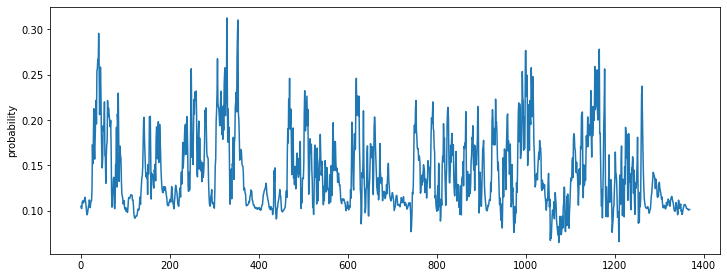

In [0]:
visualize_prediction(careful_bias_model, X_test)

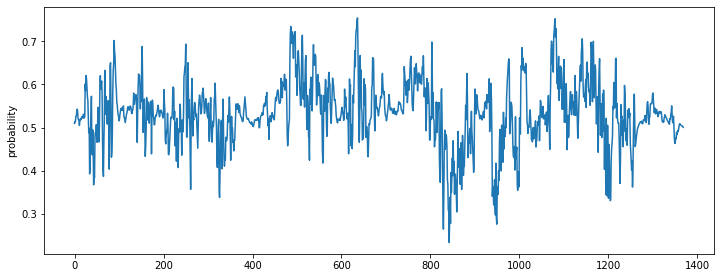

In [0]:
visualize_prediction(zero_bias_model, X_test)

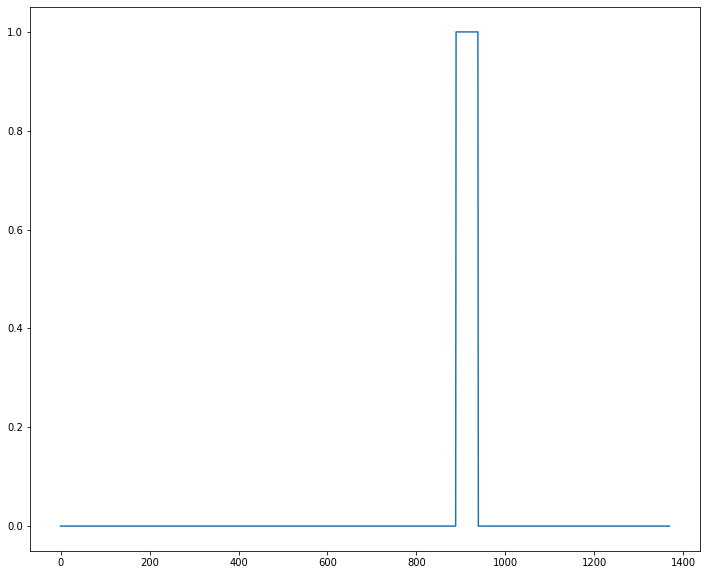

In [0]:
plt.plot(Y_test[0]) 

[Can delete the code below since `model.evaluate` is redundant now; it does not use metrics we want (ie f score)]

In [0]:
# For colab
# Function to test the model on new data
def model_test(model, X_dev, Y_dev):
    loss, acc = model.evaluate(X_dev, Y_dev)
    print("Dev set accuracy = ", acc)

In [0]:
model_test(model, X_dev, Y_dev)

50/50 [==============================] - 8s 164ms/step
Dev set accuracy =  0.9633309245109558


In [0]:
X_11 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_11X.npy")
Y_11 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_11Y.npy")
print("X: {} Y: {}".format(X_11.shape, Y_11.shape))

X_12 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_12X.npy")
Y_12 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_12Y.npy")
print("X: {} Y: {}".format(X_12.shape, Y_12.shape))

X_13 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_13X.npy")
Y_13 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_13Y.npy")
print("X: {} Y: {}".format(X_13.shape, Y_13.shape))

X_14 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_14X.npy")
Y_14 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_14Y.npy")
print("X: {} Y: {}".format(X_14.shape, Y_14.shape))








In [0]:
model_test(model, X_11, Y_11)
model_test(model, X_12, Y_12)
model_test(model, X_13, Y_13)
model_test(model, X_14, Y_14)

In [0]:
list_of_dev_ids = [11,12,13,14,20,21,22,23,24,30,31,32,33,34,35,36,37,38,39,310,40,41,42,43,44]
for id in list_of_dev_ids:
    X_id = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_" + str(id) + "X.npy")

    Y_id = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_" + str(id) + "Y.npy")
    print(("X" + str(id) + ": {} Y" + str(id) + ": {}").format(X_id.shape, Y_id.shape))
    model_test(model, X_id, Y_id)

model_test(model, X_11, Y_11)

## Hyperparameter Optimization

Redefine model train function to accept parameters...

In [0]:
import talos

# Function to fit and further train the model. Returns history (check documentation of `model.fit` for more details).
# This function is a special version being used for hyperparameter optimization.
def hyperparam_optimize(X, Y, X_dev, Y_dev, params):
    """
    Function to train the model further using Adam optimiser and binary 
    cross entropy loss.
    
    Arguments:
    model -- Model to train
    X -- X data to train on
    Y -- Y data to train on
    """
    
    model = create_model(input_shape = (Tx, n_freq), output_bias = None, dropout=params['dropout'])
    
    es = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', 
                                            min_delta=0.05, 
                                            patience=15, 
                                            verbose=1, 
                                            mode='auto', 
                                            baseline=None, 
                                            restore_best_weights=True)

    
    opt = Adam(lr=params['lr'], beta_1=0.9, beta_2=0.999, decay=0.01)
    model.compile(loss=f1_loss, optimizer=opt)
    
    history = model.fit(X, Y, batch_size=25, epochs=40, validation_data=(X_dev, Y_dev), callbacks = [es])
    return history, model

Load params to use in Talos function...

In [0]:
params = {
    'lr': [0.001, 0.003, 0.005, 0.007, 0.009, 0.01],
    'dropout': [0.3, 0.4, 0.5, 0.6, 0.7]
}

Import Talos and use...

In [0]:
import talos

scan_object = talos.Scan(X, Y, 
                         x_val=X_dev, 
                         y_val=Y_dev, 
                         model=hyperparam_optimize, 
                         params=params, 
                         experiment_name='test')

model_name = 'bryan_concat_LSTM_dropout_04'

# Save object and model
scan_object.best_model(metric='val_loss', asc=True).save(PROJ_PATH + f"models/hyperparam_scan_data/{model_name}.h5")
with open(PROJ_PATH + f'models/hyperparam_scan_data/{model_name}.pkl', 'wb') as f:
    pickle.dump(scan_object.data, f)

Get Talos data after running hyperparameter optimization...

In [0]:
# Get data
with open(PROJ_PATH + f'models/hyperparam_scan_data/{model_name}.pkl', 'rb') as f:
    data = pickle.load(f)
data